In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0
torch:  2.0 ; cuda:  cu117
detectron2: 0.6


In [2]:
import os
import sys
import logging
import argparse
os.environ["DATASET"] = "../datasets"

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from pprint import pprint
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import warnings
warnings.filterwarnings(action='ignore')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from hdecoder.BaseModel import BaseModel
from hdecoder import build_model
from utils.distributed import init_distributed
from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


Invalid MIT-MAGIC-COOKIE-1 key

In [3]:
from utils.arguments import load_vcoco_opt_command, load_vcoco_parser

cmdline_args = load_vcoco_parser()
cmdline_args.conf_files = [os.path.join(home_dir, "configs/hdecoder/vcoco_modified.yaml")]
# cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_best_openseg.pt'] 
cmdline_args.overrides = ['DONT_LOAD_MODEL', 'false', 'PYLEARN_MODEL', '../data/output/test/00062100/default/raw_model_states.pt'] 

opt = load_vcoco_opt_command(cmdline_args)
opt = init_distributed(opt)

In [4]:
import json
from detectron2.structures import BoxMode
image_root = home_dir + "/datasets/v-coco/images/train2014"
anno_file = home_dir + "/datasets/v-coco/annotations/trainval_vcoco.json"
print(anno_file)
def load_vcoco_json(image_root, anno_file):
    json_file = os.path.join(anno_file)
    with open(json_file) as f:
        vcoco_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(vcoco_anns):
        record = {}
        record["id"] = idx
        for key, val in v.items():
            if key == "file_name":
                record[key] = os.path.join(image_root, v["file_name"])
            else:
                record[key] = val
                if key == "annotations":
                    for anno in v[key]:
                        anno["bbox_mode"] = BoxMode.XYWH_ABS
        dataset_dicts.append(record)
    return dataset_dicts

/home/djjin/Mygit/X-Decoder/datasets/v-coco/annotations/trainval_vcoco.json


In [5]:
from datasets.build import build_train_dataloader
train_data_loader = build_train_dataloader(opt)
dataset_names = opt['DATASETS']['TRAIN']
print(len(train_data_loader))

{'PIPELINE': 'HDecoderPipeline', 'TRAINER': 'hdecoder', 'SAVE_DIR': 'data/output/test', 'base_path': '../', 'WANDB': True, 'AUX_LOSS': True, 'RESUME': False, 'WEIGHT': False, 'RESET_DATA_LOADER': False, 'RESUME_FROM': '', 'PYLEARN_MODEL': '../data/output/test/00062100/default/raw_model_states.pt', 'DONT_LOAD_MODEL': False, 'LOG_EVERY': 10, 'FIND_UNUSED_PARAMETERS': False, 'FP16': False, 'PORT': '36873', 'LOADER': {'JOINT': True, 'KEY_DATASET': 'coco'}, 'VERBOSE': True, 'MODEL': {'NAME': 'hoi_model', 'HEAD': 'hoi_head', 'MASK_ON': False, 'KEYPOINT_ON': False, 'LOAD_PROPOSALS': False, 'DIM_PROJ': 512, 'BACKBONE_DIM': 2048, 'BACKBONE': {'NAME': 'focal_dw', 'PRETRAINED': '', 'LOAD_PRETRAINED': False, 'FOCAL': {'PRETRAIN_IMG_SIZE': 224, 'PATCH_SIZE': 4, 'EMBED_DIM': 96, 'DEPTHS': [2, 2, 6, 2], 'FOCAL_LEVELS': [3, 3, 3, 3], 'FOCAL_WINDOWS': [3, 3, 3, 3], 'DROP_PATH_RATE': 0.3, 'MLP_RATIO': 4.0, 'DROP_RATE': 0.0, 'PATCH_NORM': True, 'USE_CONV_EMBED': True, 'SCALING_MODULATOR': True, 'USE_CHEC

INFO:datasets.build:Using training sampler TrainingSampler
INFO:detectron2.data.common:Serializing 5400 elements to byte tensors and concatenating them all ...


Dataset length: 5400


INFO:detectron2.data.common:Serialized dataset takes 4.09 MiB


2700


[[   0.       270.90546  736.4109  1024.     ]
 [ 122.34787  197.6005  1024.      1024.     ]
 [ 203.22482  894.524   1024.      1024.     ]
 [   0.       951.5585   786.99335 1024.     ]
 [   0.       208.35558  106.64894  522.83484]
 [   0.       223.3224     0.       602.5326 ]
 [   0.       231.19441    0.       605.5159 ]]


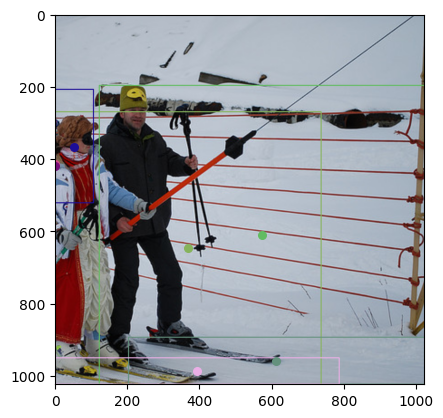

[[2.21393700e+01 4.61865616e+01 7.61179047e+01 1.29106247e+02]
 [7.41345444e+01 6.04012451e+01 1.52917206e+02 1.40915939e+02]
 [6.58888092e+01 6.43967209e+01 1.37447830e+02 1.39400635e+02]
 [7.58684616e+01 6.24609375e+01 1.60075943e+02 1.51368759e+02]
 [1.14377623e+01 6.33506241e+01 3.23704872e+01 1.44336563e+02]
 [2.35062237e+01 6.07120361e+01 5.35323792e+01 1.35750488e+02]
 [7.88576965e+01 8.34579697e+01 1.60844543e+02 1.72471405e+02]
 [7.29623795e+01 7.98585892e+01 1.53164612e+02 1.61693604e+02]
 [1.58242655e+01 7.97651596e+01 3.44471321e+01 1.60147827e+02]
 [5.54832878e+01 6.47745361e+01 1.16160217e+02 1.40623444e+02]
 [9.73426551e-02 5.30481262e+01 5.84055948e+00 1.24156090e+02]
 [5.43861542e+01 4.72123413e+01 1.13396088e+02 1.01682343e+02]
 [4.98739128e+01 4.67187500e+01 1.04310768e+02 9.89137497e+01]
 [2.95698605e+01 5.92149963e+01 6.58827286e+01 1.36278595e+02]
 [2.09327278e+01 9.58871841e+01 9.61400681e+01 2.23975784e+02]
 [3.49338455e+01 7.00354691e+01 8.27696533e+01 1.585309

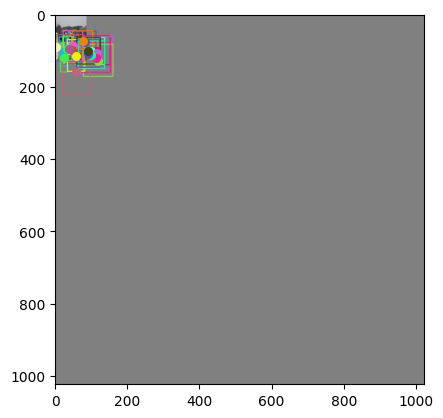

[[   0.        253.76816     0.       1024.      ]
 [   0.          0.       1024.        323.7916  ]
 [   0.          0.       1024.       1024.      ]
 [ 356.9705      0.       1024.       1024.      ]
 [ 456.40002     0.       1024.          0.      ]
 [ 348.2914    616.4286   1024.       1024.      ]
 [ 341.409     561.2015   1024.       1024.      ]
 [ 710.80536   265.4286   1024.        856.30444 ]
 [   0.        544.0913    957.8108   1024.      ]
 [   0.          0.        283.30447  1024.      ]
 [ 662.47626     0.       1024.          0.      ]
 [ 661.5017      0.       1024.          0.      ]
 [ 710.22675   269.35596  1024.        873.7494  ]
 [ 911.15656     0.       1024.        978.5409  ]
 [   0.          0.        825.82684    65.07026 ]
 [ 125.983604    0.       1024.        219.79156 ]
 [ 305.29163     0.       1024.          0.      ]]


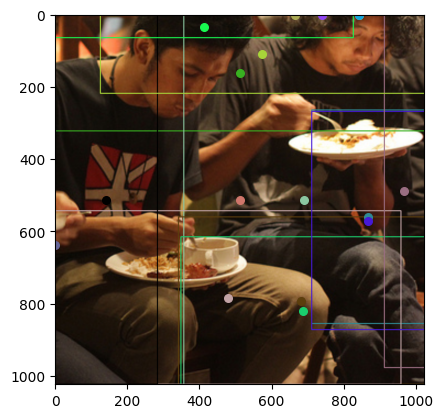

[[ 504.12915   470.34485  1024.       1024.      ]
 [ 676.78015   420.03317  1024.       1024.      ]
 [   0.        471.8168    167.98238  1024.      ]
 [ 284.26047   411.14252  1024.       1024.      ]
 [   0.        908.87195   186.46913  1024.      ]
 [ 997.6488    803.06726  1024.       1024.      ]
 [ 318.408     868.3046   1024.       1024.      ]
 [   0.        357.73972   795.4426   1024.      ]
 [ 980.16296   395.33365  1024.       1024.      ]
 [ 324.6487    568.672    1024.       1024.      ]
 [ 712.0757    826.82477  1024.       1024.      ]
 [  82.672516  851.28876   801.6835   1024.      ]]


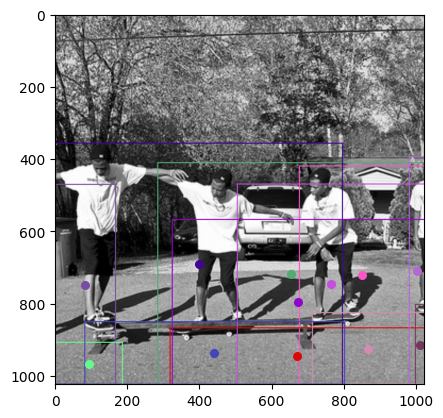

[[ 267.3459    308.046     553.93414  1024.      ]
 [   0.        472.82764   175.49026  1024.      ]
 [ 418.07492   278.99673   684.22534  1024.      ]
 [   0.        367.83112   302.73544   965.535   ]
 [   0.        400.64664   216.08755   907.87866 ]
 [ 645.5605    567.8354    696.       1024.      ]
 [  85.27229   291.91663   405.77618   623.37933 ]
 [   0.        471.59952    32.03237   980.04333 ]
 [   0.        559.84436    96.75217  1024.      ]
 [   0.        394.66974    20.355942  870.24884 ]
 [   0.        345.23364   138.90524   909.13947 ]
 [  27.659883  307.16177   372.8431    636.69226 ]
 [  27.954647  313.05673   372.2044    651.2332  ]
 [  58.824253  301.56152   382.2432    628.65216 ]
 [   0.        494.62274   345.9693   1024.      ]
 [ 437.48105   408.32648   574.2737    855.03644 ]
 [   0.        355.71362   260.90994   979.84674 ]]


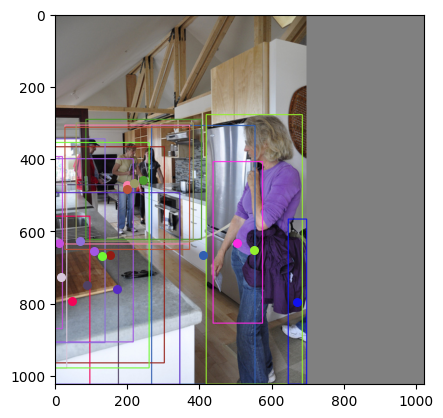

[[   0.           0.           0.         902.75134  ]
 [  51.923714     0.        1024.         507.45364  ]
 [   0.           0.        1024.        1024.       ]
 [   0.           0.        1024.         649.81555  ]
 [ 580.968      699.84906   1024.        1024.       ]
 [   0.         691.33655      0.        1024.       ]
 [  15.420496   594.5435    1024.        1024.       ]
 [   2.3007355  650.9764    1024.        1024.       ]
 [ 185.62022    459.8012    1024.        1024.       ]]


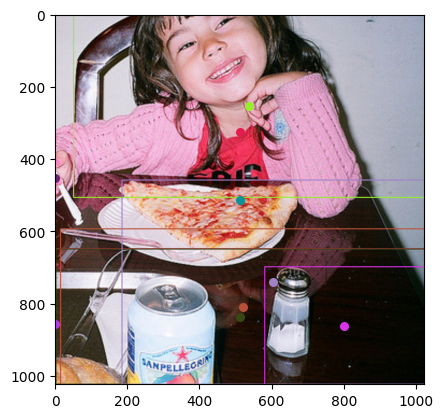

In [14]:
import cv2, random
from datasets.utils.vcoco_utils import valid_obj_ids, get_coco_instance_ID_to_name
from matplotlib import pyplot as plt
def random_color():
    rdn = random.randint(1, 1000)
    b = int(rdn * 997) % 255
    g = int(rdn * 4447) % 255
    r = int(rdn * 6563) % 255
    return b, g, r

with torch.no_grad():
    for idx, batches in enumerate(train_data_loader):
        if idx > 2:
            break
        for key, batch in batches.items():
            for idx, batch_per_image in enumerate(batch):
                obj_boxes = batch_per_image['instances'].gt_boxes.tensor
                target_img = batch_per_image["image"]
                img = target_img.permute(1, 2, 0).detach().cpu().numpy()
                obj_boxes = obj_boxes.cpu().numpy()

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                # targets_per_image = batch_per_image["instances"].to(opt.device)
                print(obj_boxes)
                for box in obj_boxes:
                    color = random_color()
                    box = box.astype(int)
                    x1, y1, x2, y2 = box
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    x = (x1 + x2) / 2
                    y = (y1 + y2) / 2

                    plt.scatter(x, y, 30, color=[i/255 for i in color])
                    # plt.text(
                    #     x + 5,
                    #     y + 5,
                    #     label,
                    #     fontsize=10,
                    #     bbox=dict(facecolor=[i/255 for i in color], alpha=0.5),
                    #     )
                
                plt.imshow(img)
                plt.show()